This is a follow-up to the ModelGroup notebook that looked at Sex effects.

Since the model that included ICV could be ran only when it was centered within group (due to rank-deficiency caused by the fact that ICV is significantly different between groups), here I will select a subset of male and females matched for age and ICV to test the differences in CT/CSA.

As in the ModelGroup, Sex is included in the group that include both sexes, and the effects of Sex and Age are examined in a model that control for ICV. 

Both age and ICV will be centered across groups.

## 1. Imports, data and output dirs


In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd

In [2]:
outdir = 'SBM_main'
os.makedirs(outdir, exist_ok=True)

In [3]:
simple_out = op.join(outdir, 'Simple_Models')
sub_info = pd.read_csv(op.join(outdir, 'subjects_info.csv'), index_col=0)

In [4]:
sub_info.head()

,Sex,Age,eTIV
mrishare_id,,,
SHARE0001,M,24.241,1.847961e+06
SHARE0002,F,22.943,1.446134e+06
SHARE0003,F,23.633,1.427213e+06
SHARE0004,M,23.107,1.825874e+06
SHARE0005,F,25.021,1.289739e+06


In [5]:
mg_out = op.join(outdir, 'Model_MatchedSex')
os.makedirs(mg_out, exist_ok=True)

In [6]:
group_out = op.join(mg_out, 'Both_AgeICVmatched')
os.makedirs(group_out, exist_ok=True)

## 2. Create Age and ICV matched male and female group

In [7]:
import epydemiology as epy

Error: pyxdameraulevenshtein package not installed. Some features may not be available.
Error: PyMSSQL package not available. Some features may not be available.


In [8]:
# create approx age and eTIV to use for matching
sub_info['Age_approx'] = np.around(sub_info.Age, decimals=0)
sub_info['eTIV_approx'] = np.around((sub_info.eTIV * 1e-6), decimals=2)
sub_info.head()

,Sex,Age,eTIV,Age_approx,eTIV_approx
mrishare_id,,,,,
SHARE0001,M,24.241,1.847961e+06,24.0,1.85
SHARE0002,F,22.943,1.446134e+06,23.0,1.45
SHARE0003,F,23.633,1.427213e+06,24.0,1.43
SHARE0004,M,23.107,1.825874e+06,23.0,1.83
SHARE0005,F,25.021,1.289739e+06,25.0,1.29


In [9]:
male_dat = sub_info[sub_info.Sex == 'M'].reset_index()
female_dat = sub_info[sub_info.Sex == 'F'].reset_index()

In [13]:
matched_df = epy.phjSelectCaseControlDataset(male_dat,
                                             female_dat,
                                             'mrishare_id',
                                             phjMatchingVariablesList=['Age_approx', 'eTIV_approx'])

In [18]:
matched_df = matched_df[~matched_df.isnull().any(axis=1)]
len(matched_df)

452

In [20]:
matched_df.head(10)

,mrishare_id,group,case,Age_approx,eTIV_approx
0,SHARE0006,2,1,23,1.76
1,SHARE1946,2,0,23,1.76
2,SHARE0007,3,1,20,1.52
3,SHARE1754,3,0,20,1.52
4,SHARE0008,4,1,24,1.65
5,SHARE0509,4,0,24,1.65
6,SHARE0009,5,1,26,1.54
7,SHARE1011,5,0,26,1.54
8,SHARE0010,6,1,24,1.67
9,SHARE1993,6,0,24,1.67


In [21]:
matched_subinfo = sub_info[sub_info.index.isin(matched_df.mrishare_id)]
len(matched_subinfo)

452

In [28]:
sub_info.groupby('Sex')[['Age', 'eTIV']].describe()

Age                                                                    \
      count       mean       std     min       25%      50%       75%     max   
Sex                                                                             
F    1320.0  22.015574  2.239367  18.144  20.50275  21.6495  23.17075  34.880   
M     514.0  22.353626  2.458055  18.081  20.58925  21.9425  23.79925  33.755   

       eTIV                                                           \
      count          mean            std           min           25%   
Sex                                                                    
F    1320.0  1.515424e+06  104577.765266  1.136622e+06  1.449672e+06   
M     514.0  1.704197e+06  117226.533482  1.365514e+06  1.622356e+06   

                                               
              50%           75%           max  
Sex                                            
F    1.513974e+06  1.580509e+06  1.917070e+06  
M    1.698709e+06  1.780562e+06  2.064348e+06

In [27]:
matched_subinfo.groupby('Sex')[['Age', 'eTIV']].describe()

Age                                                                  \
     count       mean       std     min       25%     50%      75%     max   
Sex                                                                          
F    226.0  21.974872  1.894636  18.516  20.57725  21.818  23.2605  28.569   
M    226.0  21.956814  1.864923  18.513  20.56250  21.808  23.2680  29.287   

      eTIV                                                          \
     count          mean           std           min           25%   
Sex                                                                  
F    226.0  1.626271e+06  83318.549662  1.374969e+06  1.572887e+06   
M    226.0  1.626417e+06  83740.676596  1.365514e+06  1.574852e+06   

                                               
              50%           75%           max  
Sex                                            
F    1.625633e+06  1.680803e+06  1.889673e+06  
M    1.626018e+06  1.681201e+06  1.892067e+06

In [24]:
len(male_dat)

514

In [30]:
# Save this as group info for the matched group

matched_subinfo.to_csv(op.join(group_out, 'group_info.csv'))

## 3. Create FSDG and contrast files for models with Sex

In [38]:
models = {'Model1_Sex': [],
          'Model2_Sex_Age': ['Age'],
          'Model3_Sex_ICV': ['eTIV'],
          'Model4_Sex_Age_ICV':  ['Age', 'eTIV']}

In [75]:
gm_fsgd_lines = ['GroupDescriptorFile 1', 'Class F', 'Class M']

In [40]:
# Iterate over  each model to create fsdg file

for model_name, variables in models.items():
    model_out = op.join(group_out, model_name)
    os.makedirs(model_out, exist_ok=True)
        
    var_list = ['Variables'] + variables
    extra_line = ' '.join(var_list)
    lines = gm_fsgd_lines + [extra_line]
        
    cols = ['mrishare_id', 'Sex'] + variables
    var_df = matched_subinfo.reset_index()[cols]
    var_df['Input'] = 'Input'
    col_order = ['Input', 'mrishare_id', 'Sex'] + variables
        
    fsgd_file = op.join(model_out, '{}.fsgd'.format(model_name))
    with open(fsgd_file, 'w') as f:
        for line in lines:
            f.write(line + '\n')
        var_df[col_order].to_csv(f, header=False, index=False, sep=' ')

In [36]:
contrast_dict = {'Model1': {'group.diff': [1, -1]},
                 'Model2': {'group.diff': [1, -1, 0, 0],
                            'group-x-age': [0, 0, 1, -1],
                            'FM-age': [0, 0, 0.5, 0.5]},
                 'Model3': {'group.diff': [1, -1, 0, 0],
                            'group-x-ICV': [0, 0, 1, -1],
                            'FM-ICV': [0, 0, 0.5, 0.5]},
                 'Model4': {'group.diff': [1, -1, 0, 0, 0, 0], # Is there a sex diff bet group intercept after correcting for age and eTIV?
                            'group-x-age': [0, 0, 1, -1, 0, 0], # Is there a difference bet group in the effect of age?
                            'group-x-ICV': [0, 0, 0, 0, 1, -1], # Is there a difference bet group in the effect of ICV?
                            'FM-age': [0, 0, 0.5, 0.5, 0, 0], # Is there any age effect after correcting for sex and ICV?
                            'FM-ICV': [0, 0, 0, 0, 0.5, 0.5]} # Is there any ICV effect after correcting for sex and age?
                 }

In [37]:
# For each model, create contrast.mtx file and direction of expected effects

for model_name, variables in models.items():
    model_out = op.join(group_out, model_name)
    
    contrasts = contrast_dict[model_name[:6]]
    
    for contrast_name, contrast in contrasts.items():
        contrast_file = op.join(model_out, '{}.mtx'.format(contrast_name))
        contrast_sign_file = op.join(model_out, '{}.mdtx'.format(contrast_name))
        
        with open(contrast_file, 'w') as f:
                f.write(' '.join(str(val) for val in contrast))
            
        with open(contrast_sign_file, 'w') as f:
            f.write('abs') 

These models were run with run_MatchedGroup_model_SBM.sh in /data/extra/tsuchida/MRiShare/SBM.

## 4. Create a larger age- and ICV-matched group

After reading some papers on ICV correction methods and sex differences (most notably Nordenskjold et al 2015 and Pintzka et al 2015), I came to the conclusion that the matched group is crucial for really testing for sex differences or sex interactions. The main drawback from matched group is a much reduced sample size.

To increase the power of matched group comparison, I will relax the age-matching requirement. Rather than matching age and ICV together, age will be matched more loosely by age-stratified group, and then for each group, ICV-matched pairs will be made.

To make it easy to compare the results across the 3 groups, plot all the equivalent images across them.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

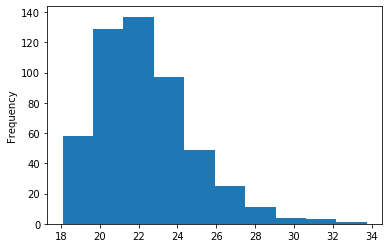

In [11]:
male_dat['Age'].plot.hist()

In [7]:
surf_measures = ['thickness', 'area']

In [28]:
age_groups = [(18, 21), (21, 24), (24, 27), (27, 30), (30, 35)]
male_grouped_dat = []
female_grouped_dat = []
for l, u in age_groups:
    m_group = male_dat[(male_dat.Age >= l) & (male_dat.Age < u)]
    print ('{} - {}: {}'.format(l, u, len(m_group)))
    male_grouped_dat.append(m_group)
    
    f_group = female_dat[(female_dat.Age >= l) & (female_dat.Age < u)]
    print ('{} - {}: {}'.format(l, u, len(f_group)))
    female_grouped_dat.append(f_group)

18 - 21: 164
18 - 21: 481
21 - 24: 238
21 - 24: 620
24 - 27: 85
24 - 27: 176
27 - 30: 23
27 - 30: 34
30 - 35: 4
30 - 35: 9


In [29]:
matched_groups = []
for age_range, m_group, f_group in zip(age_groups, male_grouped_dat, female_grouped_dat):
    matched = epy.phjSelectCaseControlDataset(m_group,
                                              f_group,
                                             'mrishare_id',
                                              phjMatchingVariablesList=['eTIV_approx'])
    matched_df = matched[~matched.isnull().any(axis=1)]
    l, u = age_range
    print ('{} - {}: {}/{}'.format(l, u, len(matched_df), len(matched)))
    matched_groups.append(matched_df)

18 - 21: 180/328
21 - 24: 270/476
24 - 27: 92/170
27 - 30: 10/46
30 - 35: 0/8


In [30]:
new_matched_subs = []
for df in matched_groups:
    new_matched_subs += df.mrishare_id.tolist()
        
len(new_matched_subs)

552

In [31]:
new_matched_subinfo = sub_info[sub_info.index.isin(new_matched_subs)]
new_matched_male = new_matched_subinfo[new_matched_subinfo.Sex == 'M']
new_matched_female = new_matched_subinfo[new_matched_subinfo.Sex == 'F']

In [22]:
from scipy import stats

In [32]:
stats.ttest_ind(new_matched_male.Age, new_matched_female.Age)

Ttest_indResult(statistic=0.6677361403653197, pvalue=0.5045821197003613)

In [84]:
new_matched_subinfo.groupby('Sex')[['Age', 'eTIV']].describe()

Age                                                                    \
     count       mean       std     min       25%      50%       75%     max   
Sex                                                                            
F    276.0  21.995757  2.008845  18.182  20.61250  21.7945  23.09725  29.467   
M    276.0  22.113873  2.144905  18.272  20.55825  21.8740  23.59125  29.845   

      eTIV                                                          \
     count          mean           std           min           25%   
Sex                                                                  
F    276.0  1.632083e+06  86360.096249  1.371705e+06  1.577870e+06   
M    276.0  1.632272e+06  86513.469561  1.365514e+06  1.577142e+06   

                                               
              50%           75%           max  
Sex                                            
F    1.630624e+06  1.686490e+06  1.917070e+06  
M    1.631411e+06  1.685793e+06  1.916886e+06

In [37]:
# Create a new model and group dir to save the newly matched sub info

mg2_out = op.join(outdir, 'Model_MatchedSex2')
os.makedirs(mg2_out, exist_ok=True)

new_group_out = op.join(mg2_out, 'Both_AgeICVmatched_552')
os.makedirs(new_group_out, exist_ok=True)

In [36]:
new_matched_subinfo.tail()

,Sex,Age,eTIV,Age_approx,eTIV_approx
mrishare_id,,,,,
SHARE1983,M,21.306,1.544438e+06,21.0,1.54
SHARE1986,F,19.165,1.676667e+06,19.0,1.68
SHARE1989,F,20.799,1.683224e+06,21.0,1.68
SHARE1993,F,24.350,1.665072e+06,24.0,1.67
SHARE1997,M,29.845,1.457577e+06,30.0,1.46


In [38]:
# Create a demeaned age , age^2, and eTIV
new_matched_subinfo['AgeC'] = new_matched_subinfo.Age - new_matched_subinfo.Age.mean()
new_matched_subinfo['SqAgeC'] = new_matched_subinfo.AgeC**2
new_matched_subinfo['eTIVC'] = new_matched_subinfo.eTIV - new_matched_subinfo.eTIV.mean()
    
new_matched_subinfo.head()

/homes_unix/tsuchida/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/homes_unix/tsuchida/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes_unix/tsuchida/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,Sex,Age,eTIV,Age_approx,eTIV_approx,AgeC,SqAgeC,eTIVC
mrishare_id,,,,,,,,
SHARE0004,M,23.107,1.825874e+06,23.0,1.83,1.052185,1.107093,193696.627542
SHARE0006,M,22.916,1.756562e+06,23.0,1.76,0.861185,0.741639,124384.829602
SHARE0007,M,20.011,1.523241e+06,20.0,1.52,-2.043815,4.177181,-108936.184548
SHARE0008,M,23.715,1.648408e+06,24.0,1.65,1.660185,2.756214,16230.162452
SHARE0009,M,25.889,1.541881e+06,26.0,1.54,3.834185,14.700973,-90297.002888


In [39]:
new_matched_subinfo.to_csv(op.join(new_group_out, 'group_info.csv'))

## 5 Create design matrices and contrasts

To have a better control over the modelling, create design matrices directly, to use in the GLM, rather than FSGD files.
This is needed for the test of main effects when interaction was deemed non-significant (i.e. DOSS design).

In [40]:
import scipy.io as sio

In [44]:
test_mat = '/beegfs_data/scratch/tsuchida-SBM/SBM_Both/_model_name_Model8_Sex_Age/_measure_area/_fwhm_0.0/lhSBMglmfit/X.mat'
test_contents = sio.loadmat(test_mat)
test_contents

{'X': array([[ 0.        ,  1.        ,  0.        ,  2.13068271],
        [ 1.        ,  0.        ,  0.83268267,  0.        ],
        [ 1.        ,  0.        ,  1.52268267,  0.        ],
        ...,
        [ 1.        ,  0.        , -1.19031739,  0.        ],
        [ 0.        ,  1.        ,  0.        ,  7.33568287],
        [ 0.        ,  1.        ,  0.        ,  5.22468281]])}

In [45]:
test_contents['X'].shape

(1834, 4)

In [55]:
# Here all models include Sex, AgeC, eTIVC varialbles
# but interaction terms are formed between Sex and var specified in dict
new_models = {'Model1a_Sex_Age_ICV_simple': [],
              'Model1b_Sex_Age_ICV_intSexAge': ['AgeC'],
              'Model1c_Sex_Age_ICV_intSexICV': ['eTIVC'],
              'Model1d_Sex_Age_ICV_intSexAge_intSexICV':  ['AgeC', 'eTIVC']}

In [64]:
variables = ['Sex', 'AgeC', 'eTIVC']
def f_fxn(row):
    return 1.0 if row.Sex == 'F' else 0.0
def m_fxn(row):
    return 1.0 if row.Sex == 'M' else 0.0

model_designs = {}
for model_name, int_variables in new_models.items():
    model_out = op.join(new_group_out, model_name)
    os.makedirs(model_out, exist_ok=True)
    
    model_designs[model_name] = {}
    
    df = new_matched_subinfo[variables]
    df['Female'] = df.apply(f_fxn, axis=1)
    df['Male'] = df.apply(m_fxn, axis=1)
    
    cols = ['Female', 'Male', 'AgeC', 'eTIVC']
    
    for int_var in int_variables:
            df['{}_F'.format(int_var)] = df.Female * df[int_var]
            df['{}_M'.format(int_var)] = df.Male * df[int_var]
            cols = cols[:cols.index(int_var)] + ['{}_F'.format(int_var), '{}_M'.format(int_var)] + cols[cols.index(int_var)+1:]
    model_designs[model_name]['X'] = df[cols].values
    
    # save mat
    sio.savemat(op.join(model_out, 'X.mat'), model_designs[model_name])

/homes_unix/tsuchida/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/homes_unix/tsuchida/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/homes_unix/tsuchida/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [65]:
# new contrasts

new_contrast_dict = {'Model1a': {'group.diff': [[1, -1, 0, 0]], # Sex diff after controlling for age, eTIV, if no interaction
                                 'FM-age': [[0, 0, 1, 0]],      # Age effect after controlling for sex, eTIV, if no interaction
                                 'FM-ICV': [[0, 0, 0, 1]]},     # eTIV effect after controlling for sex, age, if no interaction
                     'Model1b': {'group.diff': [[1, -1, 0, 0, 0]],  # Sex diff at mean age, after controlling for eTIV
                                 'group-x-age': [[0, 0, 1, -1, 0]], # Sex x Age interaction, controlling for eTIV
                                 'FM-ICV': [[0, 0, 0, 0, 1]]},      # eTIV effect after controlling for sex, age, if no interaction of Sex and eTIV
                     'Model1c': {'group.diff': [[1, -1, 0, 0, 0]],  # Sex diff at mean eTIV, after controlling for age
                                 'group-x-ICV': [[0, 0, 0, 1, -1]], # Sex x eTIV interaction, controlling for age
                                 'FM-age': [[0, 0, 1, 0, 0]]},        # Age effect after controlling for sex, eTIV, if no interaction of Sex and age
                     'Model1d': {'group.diff': [[1, -1, 0, 0, 0, 0]], # Sex diff at mean age and eTIV
                                 'group-x-age': [[0, 0, 1, -1, 0, 0]],  # Is there a difference bet group in the effect of age?
                                 'group-x-ICV': [[0, 0, 0, 0, 1, -1]],  # Is there a difference bet group in the effect of ICV?
                                 'group-x-age-or-ICV': [[0, 0, 1, -1, 0, 0],
                                                        [0, 0, 0, 0, 1, -1]]} # Is there any interaction between age OR ICV?
                                 
                     }

In [72]:
# For each model, create contrast.mtx file and direction of expected effects

for model_name in list(new_models.keys()):
    model_out = op.join(new_group_out, model_name)
    
    contrasts = new_contrast_dict[model_name[:7]]
    
    for contrast_name, contrast_list in contrasts.items():
        contrast_file = op.join(model_out, '{}.mtx'.format(contrast_name))
        contrast_sign_file = op.join(model_out, '{}.mdtx'.format(contrast_name))
        
        with open(contrast_file, 'w') as f:
            lines = [' '.join(str(val) for val in contrast) for contrast in contrast_list]
            f.write('\n'.join(lines))
            
        with open(contrast_sign_file, 'w') as f:
            f.write('abs') 

In [74]:
model_designs['Model1d_Sex_Age_ICV_intSexAge_intSexICV']['X'].shape

(552, 6)

Forsome reason, model1d failed... try creating FSGD file and running it with FSGD input

In [77]:
model1d_out = op.join(new_group_out, 'Model1d_Sex_Age_ICV_intSexAge_intSexICV')
var_list = ['Variables', 'AgeC', 'eTIVC']
extra_line = ' '.join(var_list)
lines = gm_fsgd_lines + [extra_line]
        
cols = ['mrishare_id', 'Sex', 'AgeC', 'eTIVC']
var_df = new_matched_subinfo.reset_index()[cols]
var_df['Input'] = 'Input'
col_order = ['Input'] + cols
        
fsgd_file = op.join(model1d_out, '{}.fsgd'.format('Model1d_Sex_Age_ICV_intSexAge_intSexICV'))
with open(fsgd_file, 'w') as f:
    for line in lines:
        f.write(line + '\n')
    var_df[col_order].to_csv(f, header=False, index=False, sep=' ')

It's still giving the error... I'm not sure if this has something to do with centering of the variables

### 3.2. Statistical maps

In [15]:
p_out = op.join(png_out, 'Sig_maps')
os.makedirs(p_out, exist_ok=True)

In [41]:
for meas in surf_measures:
    for model_name, contrasts in simple_models.items():
        for cont in contrasts:
            fig_title = '{}: Effect of {} on {}'.format(model_name, cont, meas)
            # Get mean data for meas in each group
            lh_stat_maps = [op.join(sink_dir,
                                    'SBM_{}Sink'.format(g),
                                    '_model_name_{}'.format(model_name),
                                    '_measure_{}'.format(meas),
                                    '_fwhm_10.0',
                                    'lhSBMglmfit',
                                    cont,
                                    'sig.mgh') for g in simple_groups]
            rh_stat_maps = [op.join(sink_dir,
                                    'SBM_{}Sink'.format(g),
                                    '_model_name_{}'.format(model_name),
                                    '_measure_{}'.format(meas),
                                    '_fwhm_10.0',
                                    'rhSBMglmfit',
                                    cont,
                                    'sig.mgh') for g in simple_groups]
    
            for corr in ['corrected', 'uncorrected']:
                # Names
                out_basename = '{}_cont_{}_{}_{}P'.format(model_name, cont, meas, corr)
                if corr == 'corrected':
                    thresholds = [op.join(sink_dir, 'SBM_{}Sink'.format(g),
                                          '_model_name_{}'.format(model_name),
                                          '_measure_{}'.format(meas),
                                          '_fwhm_10.0',
                                          cont,
                                          'fdr_threshold.txt') for g in simple_groups]
                else:
                    thresholds = None

                # put in json
                dat = {'fig_title': fig_title,
                       'out_basename': out_basename,
                       'plot_type': 'surf_stat',
                       'group_names': simple_groups,
                       'lh_stat_maps': lh_stat_maps,
                       'rh_stat_maps': rh_stat_maps,
                       'upper_lim': 10.0,
                       'thresholds': thresholds,
                       'cmap': 'coolwarm'}
                json_fname = op.join(p_out, '{}_arg_dict.json'.format(out_basename))
                with open(json_fname, 'w') as f:
                    json.dump(dat, f)

In [37]:
g_out = op.join(png_out, 'Gamma_maps')
os.makedirs(g_out, exist_ok=True)

In [33]:
g_corr = ['masked', 'uncorrected']

In [42]:
for meas in surf_measures:
    for model_name, contrasts in simple_models.items():
        for cont in contrasts:
            fig_title = '{}: Effect of {} on {}'.format(model_name, cont, meas)
            # Get mean data for meas in each group
            stat_base = [op.join(sink_dir,
                                'SBM_{}Sink'.format(g),
                                '_model_name_{}'.format(model_name),
                                '_measure_{}'.format(meas),
                                '_fwhm_10.0') for g in simple_groups]
    
            for corr in g_corr:
                # Names
                out_basename = '{}_cont_{}_{}_{}G'.format(model_name, cont, meas, corr)
                if corr == 'masked':
                    lh_stat_maps = [op.join(d, 
                                            'lhSBMglmfit',
                                            cont,
                                            'gamma.mgh') for d in stat_base]
                    rh_stat_maps = [op.join(d, 
                                            'rhSBMglmfit',
                                            cont,
                                            'gamma.mgh') for d in stat_base]
                    
                else:
                    lh_stat_maps = [op.join(d, cont, 'lh.masked_gamma.mgh') for d in stat_base]
                    rh_stat_maps = [op.join(d, cont, 'rh.masked_gamma.mgh') for d in stat_base]

                # put in json
                dat = {'fig_title': fig_title,
                       'out_basename': out_basename,
                       'plot_type': 'surf_stat',
                       'group_names': simple_groups,
                       'lh_stat_maps': lh_stat_maps,
                       'rh_stat_maps': rh_stat_maps,
                       'upper_lim': None,
                       'thresholds': None,
                       'cmap': 'jet'}
                json_fname = op.join(g_out, '{}_arg_dict.json'.format(out_basename))
                with open(json_fname, 'w') as f:
                    json.dump(dat, f)